# Disease Tagging Tutorial

In this example, we'll be writing an application to extract *mentions of* diseases from Pubmed abstracts, using annotations from the [BioCreative CDR Challenge](http://www.biocreative.org/resources/corpora/biocreative-v-cdr-corpus/).  This tutorial, which has 5 parts, walks through the process of constructing a model to classify _candidate_ disease mentions as either true (i.e., that it is truly a mention of a disease) or false.

## Part I: Preprocessing

**Before starting, make sure to run the download_data.sh script!**

In this notebook, we'll preprocess several documents using `Snorkel` utilities, parsing them into a simple hierarchy of component parts of our input data--which we refer to as _contexts_--as well as extracting standard linguistic features from each context.

In this example, we will extract two types of contexts, represented as `Context` subclasses: `Document` and constituent `Sentence` objects.  In particular, we'll do this using [CoreNLP](http://stanfordnlp.github.io/CoreNLP/), which will also extract a number of standard linguistic features which will be used downstream.

All of this preprocessed input data will be saved to a database.  In Snorkel, if no database is specified, then a SQLite database is created by default- so no setup is needed here!

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession
session = SnorkelSession()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the `Corpus`

First, we will load and pre-process the corpus, storing it for convenience in a `Corpus` object

### Configuring a `DocParser`

We'll start by defining a `DocParser` class to read in Pubmed abstracts from [Pubtator]([Pubtator](http://www.ncbi.nlm.nih.gov/CBBresearch/Lu/Demo/PubTator/index.cgi)), where they are stored along with "gold" (i.e. hand-annotated by experts) *chemical* and *disease mention* annotations. We'll use the `XMLDocParser` class, which allows us to use [XPath queries](https://en.wikipedia.org/wiki/XPath) to specify the relevant sections of the XML format.

_Note that we are newline-concatenating text from the title and abstract together for simplicity, but if we wanted to, we could easily extend the `DocParser` classes to preserve information about document structure._

In [2]:
from snorkel.parser import XMLMultiDocParser

xml_parser = XMLMultiDocParser(
    path='data/CDR_TrainingSet.BioC.xml',
    doc='.//document',
    text='.//passage/text/text()',
    id='.//id/text()')

### Creating a `SentenceParser`

Next, we'll use an NLP preprocessing tool to split the `Document` objects into sentences, tokens, and provide annotations--part-of-speech tags, dependency parse structure, lemmatized word forms, etc.--for these sentences.  Here we use the default `SentenceParser` class.

In [3]:
from snorkel.parser import SentenceParser

sent_parser = SentenceParser()

### Pre-processing & loading the `Corpus`

Finally, we'll put this all together using a `CorpusParser` object, which will execute the parsers and store the results as a `Corpus`:

Number of documents: 500
CPU times: user 7.97 s, sys: 256 ms, total: 8.23 s
Wall time: 34.4 s


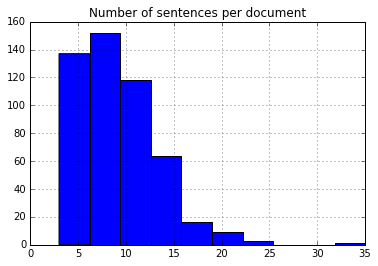

In [4]:
from snorkel.parser import CorpusParser

cp = CorpusParser(xml_parser, sent_parser)
%time corpus = cp.parse_corpus(name='CDR Training', session=session)

Note that the printed stats are a property of the `Corpus` object, and can be printed again via the `corpus.stats()` method!

In [5]:
doc = corpus.documents[0]
doc

Document 9727773

In [6]:
sent = doc.sentences[0]
print sent
print sent.words
print sent.poses

Sentence(Document 9727773, 0, u'High incidence of primary pulmonary hypertension associated with appetite suppressants in Belgium.')
[u'High', u'incidence', u'of', u'primary', u'pulmonary', u'hypertension', u'associated', u'with', u'appetite', u'suppressants', u'in', u'Belgium', u'.']
[u'JJ', u'NN', u'IN', u'JJ', u'JJ', u'NN', u'VBN', u'IN', u'NN', u'NNS', u'IN', u'NNP', u'.']


### Saving the `Corpus`
Finally, we persist the parsed corpus in Snorkel's database backend:

In [7]:
session.add(corpus)
session.commit()

### Repeating for development and test corpora
We will rerun the same operations for the other two CDR corpora: development and test. All we do is change the path that the `XMLMultiDocParser` uses.

Number of documents: 500
CPU times: user 7.69 s, sys: 179 ms, total: 7.87 s
Wall time: 33 s


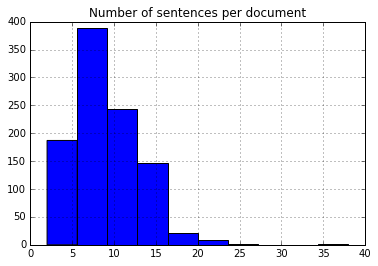

In [8]:
cp.doc_parser.path = 'data/CDR_DevelopmentSet.BioC.xml'
%time corpus = cp.parse_corpus(name='CDR Development', session=session)
session.add(corpus)

Number of documents: 500
CPU times: user 7.72 s, sys: 174 ms, total: 7.89 s
Wall time: 34.3 s


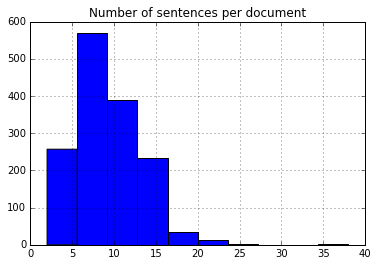

In [9]:
cp.doc_parser.path = 'data/CDR_TestSet.BioC.xml'
%time corpus = cp.parse_corpus(name='CDR Test', session=session)
session.add(corpus)

In [10]:
session.commit()

In [11]:
## This cell is just for speeding up automatic testing. You can safely ignore it!
import os
if 'CI' in os.environ:
    from snorkel.models import Corpus
    import random
    for corpus_name in ['CDR Training', 'CDR Development', 'CDR Test']:
        corpus = session.query(Corpus).filter(Corpus.name == corpus_name).one()
        docs = set([d for d in corpus.documents])
        for doc in docs:
            if random.random() > .10:
                corpus.remove(doc)
    session.commit()

Next, in Part 2, we will look at how to extract `Candidate` relations from our saved `Corpus`.